# Cross Validation, Model Selection & Regularisation

In this notebook we will introduce the concepts below, and how they can be implemented in `scikit-learn`.
* Cross validation - a method for estimating the test error rate when test data is not available
* Model selection - how we use cross validation to select which model (from a selection) we should use for a particular data set
* Regularisation - an adaptation of linear regression to make it more flexible

[This video](https://www.youtube.com/watch?v=DQWI1kvmwRg) describes some of the ideas you will face in the coming notebook. The ideas we are covering here are described much more throughly in **ISLR** (see suggested sections in module overview).

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sklearn.metrics as metrics

from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet


## Cross validation

We have already seen the notion of splitting *test* and *training sets* in order to asses model performance. Now we will introduce the idea of *validation sets*.

Once again **ISTL** (Section 5.1) provides a very clear overview of how these technqiues work:

>Resampling methods are an indispensable tool in modern statistics. They
involve repeatedly drawing samples from a training set and refitting a model
of interest on each sample in order to obtain additional information about
the fitted model. For example, in order to estimate the variability of a linear
regression fit, we can repeatedly draw different samples from the training
data, fit a linear regression to each new sample, and then examine the
extent to which the resulting fits differ. Such an approach may allow us to
obtain information that would not be available from fitting the model only
once using the original training sample.

>Resampling approaches can be computationally expensive, because they
involve fitting the same statistical method multiple times using different
subsets of the training data. However, due to recent advances in computing
power, the computational requirements of resampling methods generally
are not prohibitive. [...] cross-validation can be used to estimate the test
error associated with a given statistical learning method in order to evaluate
its performance, or to select the appropriate level of flexibility. The process
of evaluating a model’s performance is known as model assessment, whereas model
the process of selecting the proper level of flexibility for a model is known as assessment
model selection.

The [diagram](https://towardsdatascience.com/train-validation-and-test-sets-72cb40cba9e7) below illustrates this process. Here the train and validation sets are used to do model assesment and model selection (NOTE: the test set is strictly forbidden from being used in any way during this process!). Once a model is selected the test set is used to do a final assesment of performance to see if the model selected will generalise as well as predicted.

<img src="./../images/testtrainvalid.png" width="450px">

There is a simple overview these ideas [here](https://towardsdatascience.com/train-validation-and-test-sets-72cb40cba9e7), and a more thorough overview [here](https://machinelearningmastery.com/difference-test-validation-datasets/).

### K-fold cross validation

A very common method called *k-fold* is often used, which actually splits the training set multiple times. This allows us to assess the accuracy of the model over $k$ validation splits of data. The [image below](http://ethen8181.github.io/machine-learning/model_selection/model_selection.html) illustrates how this works for $k = 5$ splits.

<img src="./../images/kfold.png" width="450px">

The `scikit-learn` documentation offers a simple [example](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) of implementing k-fold on some dummy data. We will examine this below. NOTE: The `scikit-learn` documentation is **FANSTASTIC(!)** and contains working examples of every function, it should always be the first place you look when you wish to implement a new function.

**Task 1:** 

* Have a look at the code below and check you understand what is going on. (Add some print statements in various places to help.)

In [2]:
import numpy as np
from sklearn.model_selection import KFold
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([1, 2, 3, 4])
kf = KFold(n_splits=3,shuffle=False) # here we choose the number of folds (or splits) we will make
kf.get_n_splits(X)

print(kf)

for train_index, valid_index in kf.split(X): # kf.split(X) is an iterable which gives us the indices of the data in each fold
    print("TRAIN:", train_index, "VALID:", valid_index)
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

KFold(n_splits=3, random_state=None, shuffle=False)
TRAIN: [2 3] VALID: [0 1]
TRAIN: [0 1 3] VALID: [2]
TRAIN: [0 1 2] VALID: [3]


We can apply this to any data set to perform operations as it gives us the dataframe/numpy array indicies in each loop to select the appropriate data for each fold. For example we can apply this to the auto data set. This contains rows which correspond to individual cars and their attributes.

In [3]:
auto = pd.read_csv('./../data/Auto.csv')
auto = auto[auto.horsepower != '?']
auto['horsepower'] = auto.horsepower.astype(int)
auto.reset_index(inplace=True, drop=True)
auto.head()
# len(auto)

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [4]:
mpg = auto.pop('mpg') # mpg will be our target and so we remove this into a seperate array

Say we are trying to predict 'mpg' from our other automobile data features. We can use KFold to iterate over the number of splits we choose.

**Task 2:**
* try adding print statements for the size of the dataframes in each split
* try increasing the number of splits and re-run your code
* use the code below to print a car name contained in the train and validation data set, for each split



In [5]:
kf = KFold(n_splits=5) # here we choose the number of folds (or splits) we will make
kf.get_n_splits(auto)

print(kf)


split_counter = 1
for train_index, valid_index in kf.split(auto): # kf.split(X) is an iterable which gives us the indices of the data in each fold
    print('-'*30)
    print('This is split no: {}'.format(split_counter))
    kf.split(split_counter)
    print("TRAIN:", len(train_index), "VALID:", len(valid_index))
    split_counter += 1 
    X_train, X_valid = auto.iloc[train_index], auto.iloc[valid_index] # must use .iloc because its a dataframe this time
    y_train, y_valid = mpg[train_index], mpg[valid_index]
    
    # your code here
    print("Train car name example:",X_train['name'].iloc[0])
    print('Validation car name example:',X_valid['name'].iloc[0])

KFold(n_splits=5, random_state=None, shuffle=False)
------------------------------
This is split no: 1
TRAIN: 313 VALID: 79
Train car name example: ford pinto (sw)
Validation car name example: chevrolet chevelle malibu
------------------------------
This is split no: 2
TRAIN: 313 VALID: 79
Train car name example: chevrolet chevelle malibu
Validation car name example: ford pinto (sw)
------------------------------
This is split no: 3
TRAIN: 314 VALID: 78
Train car name example: chevrolet chevelle malibu
Validation car name example: buick century
------------------------------
This is split no: 4
TRAIN: 314 VALID: 78
Train car name example: chevrolet chevelle malibu
Validation car name example: dodge colt m/m
------------------------------
This is split no: 5
TRAIN: 314 VALID: 78
Train car name example: chevrolet chevelle malibu
Validation car name example: dodge aspen


n_splits=2 means that we are dividing our dataframe into 2 groups of 196 cars (out of 392).<br>
When using n_splits=2 we are switching train and valid, thereofore the first car in the former train set becomes the first car in the validation set.<br>
n_splits=N means that we are dividing df into a train set of (392/N)x(N-1) and a valid set of 392/N cars.<br>
The valid set is different for every splits. The first car in the valid set in the first split becomes the first car in the trains et for all others sets.

In [6]:
auto = auto.drop('name', axis=1, errors='ignore') # we do not need the car names so remove for now.

We can use the same loop to fit and evaluate our linear regression model on each train/validation split:

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


split_counter = 1
mse_scores = [] # create empty list of scores for each split
kf = KFold(n_splits=5)
kf.get_n_splits(auto)

for train_index, valid_index in kf.split(auto): # kf.split(X) is an iterable which gives us the indices of the data in each fold
    print('-'*30)
    print('This is split no: {}'.format(split_counter))
    split_counter += 1 
    X_train, X_valid = auto.iloc[train_index], auto.iloc[valid_index] # must use .iloc because its a dataframe this time
    y_train, y_valid = mpg[train_index], mpg[valid_index]
    
    
    #### fit polynomial to train data in this split
    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)
    
    #### eval & print MSE training results in this split
    mpg_train_pred = lin_reg.predict(X_train)
    mse_train = mean_squared_error(y_train, mpg_train_pred)
    print('training MSE: {0}'.format(mse_train))
    
    #### do the same for validation split
    mpg_valid_pred = lin_reg.predict(X_valid)
    mse_valid = mean_squared_error(y_valid, mpg_valid_pred)
    print('validation MSE: {0}'.format(mse_valid))
    
    mse_scores.append(mse_valid) # assign validation MSE score to list
    

------------------------------
This is split no: 1
training MSE: 11.284070590566003
validation MSE: 14.974307651304148
------------------------------
This is split no: 2
training MSE: 11.155158050598772
validation MSE: 10.905952427081184
------------------------------
This is split no: 3
training MSE: 12.160105136871522
validation MSE: 5.991708610108182
------------------------------
This is split no: 4
training MSE: 9.921674145405687
validation MSE: 15.587544657621603
------------------------------
This is split no: 5
training MSE: 7.977511689294956
validation MSE: 27.844743081984205


When using k-fold cross validation we can analyse the validation MSE result for each split to assess the overall performance.

In [8]:
mse_scores  = np.array(mse_scores)
print('VALIDATION SET MSE SCORES')
print('mean MSE:', mse_scores.mean())
print('std MSE:', mse_scores.std())

VALIDATION SET MSE SCORES
mean MSE: 15.060851285619865
std MSE: 7.255691814890926


#### Cross validation in practice in sklearn
Most of the time we do not care about having access to each split. `Scikit-Learn` provide a much easier way to do all of this with the function `cross_val_score`. This allows us to do the same as above but in much less code.

In [9]:
from sklearn.model_selection import cross_val_score
lin_reg = LinearRegression()

cv_scores = cross_val_score(lin_reg, auto, mpg, cv = 10, scoring='neg_mean_squared_error')

#'neg_mean_squared_error' since the way they actually optimize it 
#is by taking its negative and maximizing that instead of minimizing the actual error.
#Returns the 'negative MSE' for each splits.

#cv is the number of splits (5 by default).

print('mean MSE:',np.mean(-cv_scores))
print('std MSE:',np.std(-cv_scores))

cv_scores

mean MSE: 12.65795467177642
std MSE: 7.174144488808771


array([ -9.58828251,  -8.87472359, -11.57301071,  -8.30423008,
        -4.6629437 ,  -6.74765794, -18.41064555, -12.59276339,
       -30.92977951, -14.89550975])

Higher number of splits mean more training data, hence a better model, hence lower MSE.

**Task 3:**

* Make sure you understand the output of the cross_val_score above (i.e. What is cv_scores?)
* Investigate what the `cross_val_predict` function does.
* Import and implement this on the same data as above.
* What are the outputs of this function?
* Can you use these to evaluate the results of your cross validation?
* Do the cross-validation scores give you confidence this model is providing a useful prediction?

In [10]:
from sklearn.model_selection import cross_val_predict

lin_reg = LinearRegression()

#cross val predict trains the model on the training set and evaluates it on each element in 
#the validating set. Returns as many estimations as there is observations.
cv_scores_predict = cross_val_predict(lin_reg, auto, mpg, cv = 10)

#It resturns estimated y values, so we have to compute the MSE directly on these estimated outputs.
print('mean MSE:',mean_squared_error(cv_scores_predict,mpg))
print('std MSE:',np.std(cv_scores_predict))
print(40*'-')
print('mean RMSE:',np.sqrt(mean_squared_error(cv_scores_predict,mpg)))
print('Std data:',mpg.std())
print('Our mean RMSE is within the std of the dataset, meaning that our model may be fine.')

mean MSE: 12.64047277575063
std MSE: 7.138298630992059
----------------------------------------
mean RMSE: 3.555344255589131
Std data: 7.805007486571799
Our mean RMSE is within the std of the dataset, meaning that our model may be fine.


## Excercise 1: wine cross-validation

You must predict the alcohol content of various wines based on their other attributes.

* Split the data into train and test data sets (Ensure you use the option: `random_state = 28`).
* Perform linear regression using k-fold cross validation(ensure you use 5 folds). Return the cross validation MSE errors. Return the mean and standard deviations of these.
* Evaluate the performance of the model on the test set.
* Compare the cross-validation error and the test error (MSE). What do you find? 
* Try removing the random_state option. What happens to your results? Explain why.

In [ ]:
#Ridge

#Train and test data sets
hitters_stan_x_train, hitters_stan_x_test, hitters_stan_y_train, hitters_stan_y_test = train_test_split(hitters_stan, hitters_stan_y, random_state = 28)
#Lasso
ridge = Ridge(max_iter=10000)

param_grid =[{'alpha': np.linspace(1,100,100)},]

randomized_search = RandomizedSearchCV(ridge, param_grid,n_iter=100, cv=10, scoring='neg_mean_squared_error')
randomized_search.fit(hitters_stan_x_train, hitters_stan_y_train)

randomized_results = pd.DataFrame(randomized_search.cv_results_)
randomized_results.sort_values(by=['rank_test_score'],inplace=True)

In [81]:
from sklearn.model_selection import train_test_split

wine_x = pd.read_csv('./../data/wine.csv')
wine_x.head()
wine_y = wine_x.pop('Alcohol')

lin_reg_wine = LinearRegression()


wine_x_train, wine_x_test, wine_y_train, wine_y_test = train_test_split(wine_x, wine_y, random_state = 28)

# lin_reg = LinearRegression()

cv_scores_wine = cross_val_score(lin_reg_wine, wine_x_train, wine_y_train, cv = 5, scoring='neg_mean_squared_error')
lin_reg_wine.fit(wine_x_train,wine_y_train)
# cv_scores_predict_wine = cross_val_predict(lin_reg, wine_x, wine_y, cv = 5)
#'neg_mean_squared_error' since the way they actually optimize it 
#is by taking its negative and maximizing that instead of minimizing the actual error.
#Returns the 'negative MSE' for each splits.

#cv is the number of splits (5 by default).

print('mean MSE:',np.mean(-cv_scores_wine))
print('std MSE:',np.std(-cv_scores_wine))
wine_y_pred_test = lin_reg_wine.predict(wine_x_test)
test_mse=metrics.mean_squared_error(wine_y_pred_test,wine_y_test)
print('test MSE:',test_mse)
print(35*'-')
print('mean data',np.mean(wine_y))
print('std data',np.std(wine_y))
print(35*'-')
print('Doing linear regression again on the whole training set, and applying it on the test set.')


# predict y values for testing data set
model = LinearRegression()
model.fit(wine_x, wine_y)
# evaluate MSE
wine_y_pred_train = model.predict(wine_x_train)
mse_train = mse_test = metrics.mean_squared_error(wine_y_train, wine_y_pred_train)
wine_y_pred_test = model.predict(wine_x_test)
print('train RMSE:{0}'.format(np.sqrt(mse_train)))
mse_test = metrics.mean_squared_error(wine_y_test, wine_y_pred_test)
print('test RMSE: {0}'.format(np.sqrt(mse_test)))
print('train MSE:{0}'.format(mse_train))
mse_test = metrics.mean_squared_error(wine_y_test, wine_y_pred_test)
print('test MSE: {0}'.format(mse_test))
print('The test RMSE is usually higher than the test RMSE, because our model performs better on the data it was fitted on.')
print('Removing "random state" means that the split will be complretely random, therefore the model will always differ.')

mean MSE: 0.4771472419568702
std MSE: 0.13726764524713428
test MSE: 0.4772283117698694
-----------------------------------
mean data -0.00011235955056161073
std data 0.9968145831688199
-----------------------------------
Doing linear regression again on the whole training set, and applying it on the test set.
train RMSE:0.6110685980980046
test RMSE: 0.6326605751954714
train MSE:0.3734048315814607
test MSE: 0.40025940340666466
The test RMSE is usually higher than the test RMSE, because our model performs better on the data it was fitted on.
Removing "random state" means that the split will be complretely random, therefore the model will always differ.


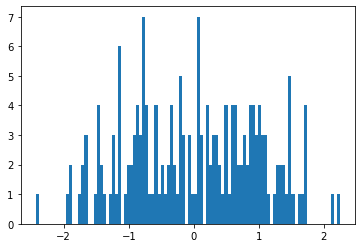

In [12]:
plt.hist(wine_y,bins=100);

In [13]:
# plt.scatter(wine_y,cv_scores_predict_wine)

In [14]:
# plt.scatter(wine_y_test,wine_y_pred_test)

## Regularisation

An alternative to choosing models which contains smaller numbers of features is to use a method that *constrains* or *regularises* the coefficent estimates assigned to each feature, or that shrinks the coefficient towards zero. This technique is very similar to *least squares* which we have been using until now. Please refer to Section in 6.2 **ISTL** for a fuller explanation of this.

When we move to use a regularised linear regression for prediction the additional term means that we now have a model parameter that requires setting. These terms are referred to as *hyperparameters* in machine learning. In practice this introduces another additional unknown parameter which we must choose somewhere in our modelling. It is common practice to run several models, each with different values of this hyperparameter, and then assess the error of each using cross validation for comparison.

For now we will focus on how to implement Lasso and Ridge regression in sklearn. These are both types of regularised linear regression.

#### Lasso regression in sklearn

In this example we aim to predict credit rating of individual customers. To train and predict using a Lasso regression we follow much the same procedure as we have seen before in `scikit-learn`.

### Regularisation with wine dataset

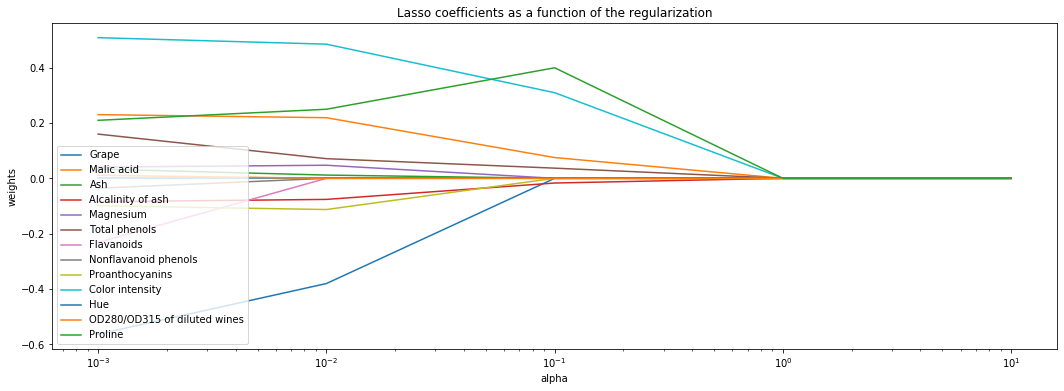

In [15]:
alphas = [0.001, 0.01, 0.1, 1, 3, 10]
coefs = []
mse = []
variable=wine_x.columns.values
for a in alphas:
    ridge2_plot = Lasso(alpha=a)
    ridge2_plot.fit(wine_x_train, wine_y_train)
    coefs.append(ridge2_plot.coef_)
    mse.append(mean_squared_error(ridge2_plot.predict(wine_x_train), wine_y_train))

plt.figure(figsize=(18,6))    
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization')
plt.plot(alphas, coefs,label=variable)
plt.legend(variable);

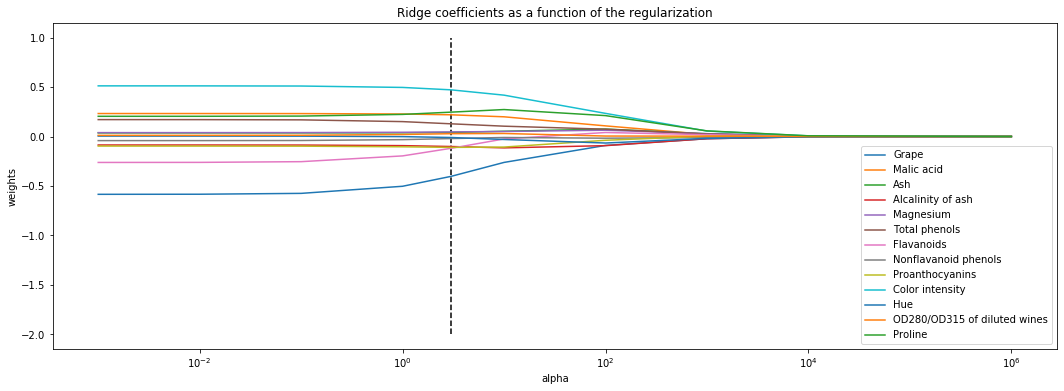

In [16]:
alphas = [0.001, 0.01, 0.1, 1, 3, 10, 100, 1000, 10000, 1000000]
coefs = []
mse = []
variable=wine_x.columns.values
for a in alphas:
    ridge2_plot = Ridge(alpha=a)
    ridge2_plot.fit(wine_x_train, wine_y_train)
    coefs.append(ridge2_plot.coef_)
    mse.append(mean_squared_error(ridge2_plot.predict(wine_x_train), wine_y_train))

plt.figure(figsize=(18,6))    
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.vlines(3, -2.0, 1.0, 'black', linestyle = '--')
plt.plot(alphas, coefs,label=variable)
plt.legend(variable);

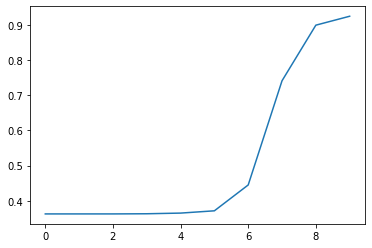

In [17]:
plt.plot(mse);

## Credit data set

In [18]:
credit = pd.read_csv('./../data/credit_modified.csv')
rating = credit.pop('Rating')
credit.head()
credit.describe()

,Income,Limit,Cards,Age,Education,Gender,Student,Married,Balance,African American,Asian,Caucasian
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.00000,400.000000,400.0000,400.000000,400.00000
mean,45.218885,4735.600000,2.957500,55.667500,13.450000,0.517500,0.100000,0.61250,520.015000,0.2475,0.255000,0.49750
std,35.244273,2308.198848,1.371275,17.249807,3.125207,0.500319,0.300376,0.48779,459.758877,0.4321,0.436407,0.50062
min,10.354000,855.000000,1.000000,23.000000,5.000000,0.000000,0.000000,0.00000,0.000000,0.0000,0.000000,0.00000
25%,21.007250,3088.000000,2.000000,41.750000,11.000000,0.000000,0.000000,0.00000,68.750000,0.0000,0.000000,0.00000
50%,33.115500,4622.500000,3.000000,56.000000,14.000000,1.000000,0.000000,1.00000,459.500000,0.0000,0.000000,0.00000
75%,57.470750,5872.750000,4.000000,70.000000,16.000000,1.000000,0.000000,1.00000,863.000000,0.0000,1.000000,1.00000
max,186.634000,13913.000000,9.000000,98.000000,20.000000,1.000000,1.000000,1.00000,1999.000000,1.0000,1.000000,1.00000


In [19]:
#### splitting train and test set
from sklearn.model_selection import train_test_split
credit_x_train, credit_x_test, credit_y_train, credit_y_test = train_test_split(credit, rating, random_state = 91)

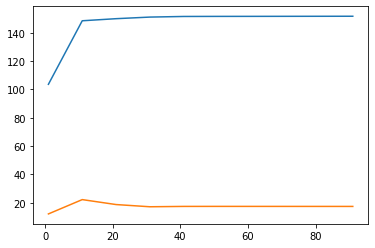

In [20]:


x=list(range(1,100,10))
mean_MSE=[]
std_MSE=[]

for i in range(1,100,10):
    lasso = Lasso(alpha = i)
    cv_scores = cross_val_score(lasso, credit_x_train, credit_y_train, cv = 5, scoring='neg_mean_squared_error')
    mean_MSE.append(np.mean(-cv_scores))
    std_MSE.append(np.std(-cv_scores))
plt.plot(x,mean_MSE)
plt.plot(x,std_MSE)

In [21]:
lasso

Lasso(alpha=91, copy_X=True, fit_intercept=True, max_iter=1000, normalize=False,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False)

Here we can alter the alpha parameter to change the amount of regularisation the model uses (try this yourself! - vary the value by at least factors of 10). With increases in regularisation we expect a reduction in the *variance* of the model.<br>
Diffrence btw L1 and L2 regularization:
https://blog.alexlenail.me/what-is-the-difference-between-ridge-regression-the-lasso-and-elasticnet-ec19c71c9028

The ridge regression can be thought of as solving an equation, where summation of squares of coefficients is less than or equal to s. And the Lasso can be thought of as an equation where summation of modulus of coefficients is less than or equal to s.

#### Using Lasso with grid search

In practice we do not want to vary hyperparameters by hand to find which value is best (the model with minimum cross validation error). Of course `scikit-learn` has a function that automates this for you. Using `GridSearchCV` we pass a dictionary of parameter values we wish to investigate. The function will fit each model we have listed and calculate the cross validation error of each. It provides all the results through the object it returns.

In [22]:
from sklearn.model_selection import GridSearchCV

lasso = Lasso(max_iter=10000)

param_grid = [
 {'alpha': [0.001, 0.01, 0.1, 1, 3, 10, 100, 1000]},
 ]

grid_search = GridSearchCV(lasso, param_grid, cv=10, scoring='neg_mean_squared_error')
grid_search.fit(credit_x_train, credit_y_train)

grid_results = pd.DataFrame(grid_search.cv_results_)

grid_results.head(20)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.007574,0.000184,0.001724,0.000022,0.001,{'alpha': 0.001},-134.693531,-105.857049,-101.376944,-87.569097,-78.913304,-76.137420,-109.786540,-103.885686,-106.104721,-113.455931,-101.778022,16.450021,3
1,0.006951,0.000204,0.001712,0.000012,0.01,{'alpha': 0.01},-134.553201,-105.948212,-101.096381,-87.881139,-78.937345,-76.585584,-109.682491,-103.106018,-106.112572,-113.688788,-101.759173,16.329243,2
2,0.005538,0.000419,0.001718,0.000008,0.1,{'alpha': 0.1},-133.132694,-106.809300,-98.722275,-91.394863,-79.351692,-78.012317,-108.680986,-96.604537,-106.093953,-115.062267,-101.386489,15.688554,1
3,0.004607,0.000030,0.001708,0.000008,1,{'alpha': 1},-127.851853,-111.017555,-92.827631,-106.006184,-89.048154,-82.339570,-105.158164,-94.934777,-102.310102,-122.139519,-103.363351,13.605513,4
4,0.004442,0.000032,0.001710,0.000020,3,{'alpha': 3},-132.499698,-117.173048,-106.238114,-112.301661,-94.847286,-76.537019,-102.509314,-98.851062,-105.902336,-131.338637,-107.819817,15.910751,5
5,0.004254,0.000019,0.001702,0.000012,10,{'alpha': 10},-182.681016,-155.361568,-179.884644,-148.842090,-141.841896,-86.351859,-129.718484,-131.176340,-143.631521,-181.271903,-148.076132,28.028584,6
6,0.003966,0.000012,0.001700,0.000007,100,{'alpha': 100},-188.380866,-143.744333,-184.078341,-145.491583,-157.301014,-103.112064,-146.957766,-126.231725,-143.006029,-181.543599,-151.984732,25.542857,7
7,0.003841,0.000007,0.001697,0.000012,1000,{'alpha': 1000},-188.587767,-146.517162,-180.483375,-143.257202,-158.504388,-103.017203,-150.127246,-121.916885,-144.912869,-185.805136,-152.312923,26.074170,8


`GridSearchCV` also returns a model (with the best hyperparmeter combination it found) which has been fitted one final time to all of the training data. Therefore it is ready to make predictions on the testing set. The model can be accessed like this:

In [23]:
grid_search.best_estimator_

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [24]:
grid_search.best_estimator_.coef_

array([ 0.12317885,  0.06388352,  4.80599581, -0.0103674 , -0.23943767,
       -0.        , -0.        ,  2.39950378,  0.00975243, -0.        ,
       -3.03477967,  0.15171457])

**Task 4:**
* How many times will the lasso model be fitted when the GridSearchCV function is called above?

<details><summary>Hint</summary><br>
Check what the `refit=True` parameter does in GridSearchCV
</details>

* Look through the columns of the `grid_results` dataframe. Try and understand what the table contains.

Lasso will be fitted cv times for each value of alpha plus one extra time on the whole set (because refit=True). In this case it adds up to 81.

## Model selection

Congratulations! You have just done your first model hyperparameter tuning in `scikit-learn`! 

If we have a dataset for which we are interested in developing a predictive model. We do not know beforehand which model will perform best for this particular data or problem. Therefore, we fit and evaluate a number of different models to our data. The models could also be of varying type as well as flexibility (e.g. random forests, support vector machines, linear regression). We then need to decide which of our models we will choose to use in our final product.

As **ISLR** states:
> "we can directly estimate the test error using the validation set and cross-validation methods
discussed in Chapter 5. We can compute the validation set error or the
cross-validation error for each model under consideration, and then select
the model for which the resulting estimated test error is smallest."

This works as a simple rule, which we will follow for the remainder of this notebook. However in practice the selection can sometimes be a bit more nuanced. Read more detail [here](https://machinelearningmastery.com/a-gentle-introduction-to-model-selection-for-machine-learning/).

#### Task 5: Ridge regression in sklearn

Another type of regularised linear model is know as *Ridge regression*.

* Repeat the model prediction process above on the credit data but use a ridge regression model.
* Try replacing `GridSearchCV` with `RandomizedSearchCV`
* How do these functions differ?

In [25]:
#### your solution here

ridge = Ridge(max_iter=10000)

param_grid =[{'alpha': np.linspace(1,100000,10000)},]

grid_search = RandomizedSearchCV(ridge, param_grid,n_iter=10, cv=10, scoring='neg_mean_squared_error')
grid_search.fit(credit_x_train, credit_y_train)

grid_results = pd.DataFrame(grid_search.cv_results_)

In lasso paramters can be defined as zero (L1 regularization) while they cannot for ridge regression (L2 regularization). L2 is good to rpevent overfitting while L1 is food for interpretability (variable selection).<br>
The ridge regression has two important advantages over the linear regression. The most important one is that it penalizes the estimates. It doesn't penalize all the feature’s estimate arbitrarily. If estimates (β) value are very large, then the SSE term in the above equation will minimize, but the penalty term will increases. If estimates(β)values are small, then the penalty term in the above equation will minimize, but, the SSE term will increase due to poor generalization. So, it chooses the feature's estimates (β) to penalize in such a way that less influential features (Some features cause very small influence on dependent variable) undergo more penalization. In some domains, the number of independent variables is many, as well as we are not sure which of the independent variables influences dependent variable. In this kind of scenario, ridge regression plays a better role than linear regression.

https://www.quora.com/How-and-why-does-ridge-regression-help-with-overfitting?share=1<br>
Regularization, significantly reduces the variance of the model, without substantial increase in its bias.  So the tuning parameter λ, used in the regularization techniques described above, controls the impact on bias and variance. As the value of λ rises, it reduces the value of coefficients and thus reducing the variance. Till a point, this increase in λ is beneficial as it is only reducing the variance(hence avoiding overfitting), without loosing any important properties in the data. But after certain value, the model starts loosing important properties, giving rise to bias in the model and thus underfitting. Therefore, the value of λ should be carefully selected.

## Excercise 2: Moneyball

Moneyball, as well as being a fantastic story, is also a true story of statistical methods being applied in a real world context to make predictions for decision making. [The film Moneyball](https://www.youtube.com/watch?v=-4QPVo0UIzc) is well worth a watch if you have time. As well as in baseball most major competitive sports teams are now using data science to improve their performance, e.g. [football](http://outsideoftheboot.com/2013/06/26/rise-of-data-analysis-in-football/),...

In this excercise you have been hired by Oakland Athletics general manager Billy Beane. Your first mission is to predict the salary each player will make based on other information that is available. This will allow Billy to understand what price he should pay for players in the next transfer season.

You must:
* Import and prepare the data
* Create a train and test set
* Implement a regularised model of your choice
* Choose optimal parameters for your regularised model
* Estimate test-error using k-fold cross validation
* Calculate the true test-error

<details><summary>HINT 1</summary><br>
Some values are missing. You can drop these rows.
</details>

<details><summary>HINT 2</summary><br>
Some columns do not contain numerical values. You can drop these columns.
</details>

### clean data

In [31]:
#### note data is in the Hitters.csv file
hitters = pd.read_csv('./../data/Hitters.csv')
# auto = auto[auto.horsepower != '?']
# auto['horsepower'] = auto.horsepower.astype(int)
# auto.reset_index(inplace=True, drop=True)
# hitters.head()
# hitters.describe()
# hitters.info()4
hitters.rename(columns={'Unnamed: 0' : 'Player Name'},inplace=True)
hitters_missing_salary=hitters.loc[hitters.Salary.isnull()]
hitters.dropna(inplace=True)
# hitters_y=hitters.pop('Salary')
hitters.reset_index()
hitters_name=hitters.pop('Player Name')
hitters_leagues=hitters[['League','Division','NewLeague']].copy()
hitters.drop(['League','Division','NewLeague'],axis=1,inplace=True)
# hitters['Salary_c']=hitters.Salary
hitters_y=hitters.pop('Salary')
hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,200,11,3
4,321,87,10,39,42,30,2,396,101,12,48,46,33,805,40,4
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,282,421,25


In [27]:
# def salary_categorizing(x):
#     if x<500:
#         return 'Low'
#     elif x<1000:
#         return 'Medium'
#     else:
#         return 'High'

# hitters.Salary_c=hitters.Salary_c.apply(lambda x: salary_categorizing(x))

In [28]:
# %matplotlib inline
# import seaborn as sns

# sns.pairplot(hitters, hue='Salary_c', height=3);

### Lasso

In [32]:
#Train and test data sets
hitters_x_train, hitters_x_test, hitters_y_train, hitters_y_test = train_test_split(hitters, hitters_y, random_state = 28)
#Lasso
lasso = Lasso(max_iter=10000)

param_grid = [
 {'alpha': [0.001, 0.01, 0.1, 1, 3, 10, 100, 1000]},
 ]

grid_search = GridSearchCV(lasso, param_grid, cv=10, scoring='neg_mean_squared_error')
grid_search.fit(hitters_x_train, hitters_y_train)

grid_results = pd.DataFrame(grid_search.cv_results_)

alpha=100 yields the better result. Let's try to further optimize it.

In [33]:
#Train and test data sets
hitters_x_train, hitters_x_test, hitters_y_train, hitters_y_test = train_test_split(hitters, hitters_y, random_state = 28)
#Lasso
lasso = Lasso(max_iter=10000)

param_grid = [
 {'alpha': [115,125, 135, 145]},
 ]

grid_search = GridSearchCV(lasso, param_grid, cv=10, scoring='neg_mean_squared_error')
grid_search.fit(hitters_x_train, hitters_y_train)

grid_results = pd.DataFrame(grid_search.cv_results_)

grid_results.head(20)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.009771,0.001928,0.001670,0.000039,115,{'alpha': 115},-85976.411323,-129745.727558,-82988.444496,-62569.596502,-84467.752796,-141809.451943,-163345.075175,-262095.559238,-53078.402547,-59917.620516,-112599.404209,61048.776327,3
1,0.009791,0.002157,0.001639,0.000040,125,{'alpha': 125},-85786.457295,-129709.379600,-82875.088064,-62339.742358,-84411.068286,-141189.356629,-163592.555503,-262350.365791,-53558.916128,-59741.985538,-112555.491519,61105.270029,1
2,0.009817,0.002160,0.001637,0.000036,135,{'alpha': 135},-85606.655481,-129681.234223,-82773.319742,-62304.662349,-84360.675389,-140582.599080,-164060.637796,-262612.862673,-54216.163294,-59573.260727,-112577.207075,61149.574686,2
3,0.009726,0.002038,0.001633,0.000007,145,{'alpha': 145},-85704.300527,-129661.169366,-82685.525948,-62265.923149,-84316.523673,-139989.076764,-164542.467082,-262878.025092,-54888.626697,-59411.316365,-112634.295466,61183.417186,4


alpha=125 is the better paramater for lasso.

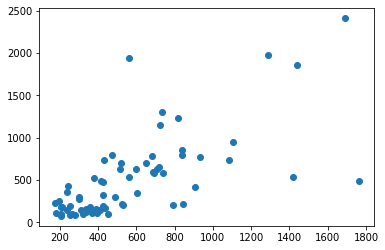

In [34]:
hitters_y_test_pred=grid_search.best_estimator_.predict(hitters_x_test)
plt.scatter(hitters_y_test_pred,hitters_y_test);

In [35]:
mse_test = metrics.mean_squared_error(hitters_y_test_pred,hitters_y_test)
print("test MSE:",mse_test)
print("test RMSE:",np.sqrt(mse_test))

test MSE: 134609.9069349766
test RMSE: 366.89222795662573


In [36]:
print("Std of original data:",hitters_y_test.std())
print("Mean of original data:",hitters_y_test.mean())

Std of original data: 496.0837308938108
Mean of original data: 515.8453484848485


**Task 6:**
* Ridge regression works best when the input variables are standardised. (See section 6.2 **ISLR** for more details.). Try standardising your data before running your model. Do you find different results?
* does this model outperform a simple linear regression model?

### Ridge (Standardizing)

#### Lasso

In [61]:
#Standardizing
hitters_stan=(hitters-hitters.mean())/hitters.std()
# hitters_stan_y=(hitters_y-hitters_y.mean())/hitters_y.std()
hitters_stan_y=hitters_y

#Train and test data sets
hitters_stan_x_train, hitters_stan_x_test, hitters_stan_y_train, hitters_stan_y_test = train_test_split(hitters_stan, hitters_stan_y, random_state = 28)
#Lasso
lasso = Lasso(max_iter=10000)

param_grid = [
 {'alpha': [0.001, 0.01, 0.1, 1, 3, 10, 100, 1000]},
 ]

grid_search = GridSearchCV(lasso, param_grid, cv=10, scoring='neg_mean_squared_error')
grid_search.fit(hitters_stan_x_train, hitters_stan_y_train)

grid_results = pd.DataFrame(grid_search.cv_results_)
grid_results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.024133,0.002377,0.002383,0.002070,0.001,{'alpha': 0.001},-87874.636556,-130508.115329,-85025.211553,-69223.813939,-86388.925487,-147302.817192,-159129.702733,-262480.269052,-46824.463129,-62870.741645,-113762.869662,60729.085809,4
1,0.017457,0.002414,0.001641,0.000009,0.01,{'alpha': 0.01},-87884.394116,-130530.516206,-85029.078434,-69226.909019,-86349.672403,-147305.580334,-158829.878286,-262499.199849,-46868.532975,-62824.425479,-113734.818710,60712.131845,3
2,0.012367,0.002029,0.001652,0.000008,0.1,{'alpha': 0.1},-88002.910980,-130775.977309,-84907.334739,-69275.278108,-85967.319856,-147926.101188,-155430.276707,-262676.630475,-47338.120633,-62456.879940,-113475.682993,60547.284044,2
3,0.009768,0.001321,0.001640,0.000011,1,{'alpha': 1},-89791.388373,-133881.471441,-84863.582325,-69381.623665,-83344.088898,-155586.171173,-136936.843501,-265691.976884,-52274.286177,-59517.881793,-113126.931423,60660.985607,1
4,0.005391,0.000565,0.001638,0.000008,3,{'alpha': 3},-87731.193223,-140367.387844,-89107.125073,-74244.314620,-83159.867547,-160125.971102,-110061.643432,-279522.428231,-58172.155364,-57501.816646,-113999.390308,63550.103012,6
5,0.003729,0.000246,0.001681,0.000091,10,{'alpha': 10},-82735.685924,-150285.307450,-86886.721194,-72176.328105,-87245.014672,-157417.960825,-101023.348842,-284218.618715,-60821.303905,-55849.154861,-113865.944449,65369.308765,5
6,0.003674,0.000136,0.001649,0.000007,100,{'alpha': 100},-127891.924177,-209577.875090,-94766.916206,-111629.790972,-101162.458409,-109105.267668,-190436.548545,-252011.464398,-89341.149420,-66851.596210,-135277.499109,57520.281217,7
7,0.003313,0.000011,0.001640,0.000010,1000,{'alpha': 1000},-198646.702739,-279162.945263,-125393.829910,-201807.954154,-138065.688496,-135180.962285,-313155.137342,-232858.580462,-154344.858941,-128291.964983,-190690.862458,63339.501428,8


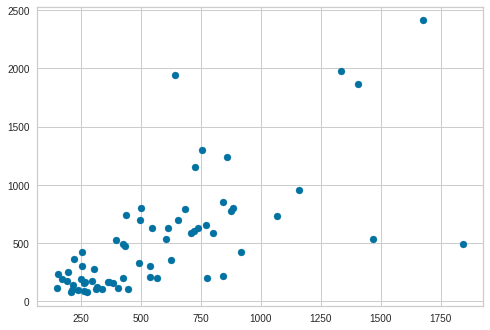

In [62]:
hitters_stan_y_test_pred=grid_search.best_estimator_.predict(hitters_stan_x_test)
plt.scatter(hitters_stan_y_test_pred,hitters_stan_y_test);

In [63]:
print("Lasso on standardized data")
mse_stan_test = metrics.mean_squared_error(hitters_stan_y_test_pred,hitters_stan_y_test)
print("MSE:",mse_stan_test)
print("RMSE:",np.sqrt(mse_stan_test))
print(30*'-')
print("RMSE in salary:",np.sqrt(mse_stan_test)*hitters_y.std()+hitters_y.mean())
print(30*'-')
print("Std of original data:",hitters_stan_y_test.std())
print("Mean of original data:",hitters_stan_y_test.mean())

Lasso on standardized data
MSE: 134102.9829754025
RMSE: 366.2007413638079
------------------------------
RMSE in salary: 165735.9211984619
------------------------------
Std of original data: 496.0837308938108
Mean of original data: 515.8453484848485


#### Ridge

In [64]:
#Ridge

#Train and test data sets
hitters_stan_x_train, hitters_stan_x_test, hitters_stan_y_train, hitters_stan_y_test = train_test_split(hitters_stan, hitters_stan_y, random_state = 28)
#Lasso
ridge = Ridge(max_iter=10000)

param_grid =[{'alpha': np.linspace(1,100,100)},]

randomized_search = RandomizedSearchCV(ridge, param_grid,n_iter=100, cv=10, scoring='neg_mean_squared_error')
randomized_search.fit(hitters_stan_x_train, hitters_stan_y_train)

randomized_results = pd.DataFrame(randomized_search.cv_results_)
randomized_results.sort_values(by=['rank_test_score'],inplace=True)

In [70]:
# # import numpy as np
# from yellowbrick.regressor import AlphaSelection
# from sklearn.linear_model import RidgeCV
# alphas = np.linspace(1,100, 100)
# # Instantiate the linear model and visualizer
# modelL = RidgeCV(alphas=alphas)
# visualizer = AlphaSelection(modelL)
# visualizer.fit(hitters_stan_x_train, hitters_stan_y_train)
# visualizer.show()

In [65]:
hitters_stan_y_test_pred=randomized_search.best_estimator_.predict(hitters_stan_x_test)

In [72]:
print("Ridge on standardized data")
mse_stan_test = metrics.mean_squared_error(hitters_stan_y_test_pred,hitters_stan_y_test)
print("MSE:",mse_stan_test)
print("RMSE:",np.sqrt(mse_stan_test))
print(30*'-')
print("RMSE in salary:",np.sqrt(mse_stan_test)*hitters_y.std()+hitters_y.mean())
print(30*'-')
print("Std of original data:",hitters_stan_y_test.std())
print("Mean of original data:",hitters_stan_y_test.mean())

Ridge on standardized data
MSE: 134366.73182079327
RMSE: 366.56067958905965
------------------------------
RMSE in salary: 165898.29605577188
------------------------------
Std of original data: 496.0837308938108
Mean of original data: 515.8453484848485


In [71]:
#Ridge

#Train and test data sets
hitters_x_train, hitters_x_test, hitters_y_train, hitters_y_test = train_test_split(hitters, hitters_y, random_state = 28)
#Lasso
ridge = Ridge(max_iter=10000)

param_grid =[{'alpha': np.linspace(1,100,100)},]

randomized_search = RandomizedSearchCV(ridge, param_grid,n_iter=100, cv=10, scoring='neg_mean_squared_error')
randomized_search.fit(hitters_x_train, hitters_y_train)

randomized_results = pd.DataFrame(randomized_search.cv_results_)
randomized_results.sort_values(by=['rank_test_score'],inplace=True)

In [73]:
hitters_y_test_pred=randomized_search.best_estimator_.predict(hitters_x_test)

In [75]:
print("Ridge on standardized data")
mse_stan_test = metrics.mean_squared_error(hitters_y_test_pred,hitters_y_test)
print("MSE:",mse_stan_test)
print("RMSE:",np.sqrt(mse_stan_test))
print(30*'-')
print("RMSE in salary:",np.sqrt(mse_stan_test)*hitters_y.std()+hitters_y.mean())
print(30*'-')
print("Std of original data:",hitters_stan_y_test.std())
print("Mean of original data:",hitters_stan_y_test.mean())

Ridge on standardized data
MSE: 135061.82272295823
RMSE: 367.5075818577873
------------------------------
RMSE in salary: 166325.46135799453
------------------------------
Std of original data: 496.0837308938108
Mean of original data: 515.8453484848485


Standardizing yields poor results, with a 3-fold increase of the RMSE...

### Elastic net

In [53]:
#Train and test data sets
hitters_x_train, hitters_x_test, hitters_y_train, hitters_y_test = train_test_split(hitters, hitters_y, random_state = 28)
#Lasso
elastic = ElasticNet(max_iter=10000)

param_grid = [
 {'alpha': [0.001, 0.01, 0.1, 1, 3, 10, 100, 1000]},
 ]

grid_search_elastic = GridSearchCV(elastic, param_grid, cv=10, scoring='neg_mean_squared_error')
grid_search_elastic.fit(hitters_x_train, hitters_y_train)

grid_results_elastic = pd.DataFrame(grid_search_elastic.cv_results_)
grid_results_elastic.sort_values(by=['rank_test_score'],inplace=True)
grid_results_elastic

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
6,0.009821,0.002239,0.001629,0.000005,100,{'alpha': 100},-86091.426710,-128620.685521,-81940.798930,-61997.516596,-84038.793836,-136549.635715,-165460.309756,-261349.772921,-53806.390449,-59030.829157,-111888.615959,60902.613668,1
7,0.007901,0.001018,0.001628,0.000008,1000,{'alpha': 1000},-91875.719368,-133558.283224,-81860.244379,-61829.470561,-83640.948049,-123020.859879,-162658.401065,-265163.714753,-67871.531234,-55556.953576,-112703.612609,60311.287479,2
5,0.015891,0.002741,0.001743,0.000172,10,{'alpha': 10},-87027.805411,-129242.352084,-83808.093343,-68424.789087,-85088.421806,-146032.643408,-159755.825292,-259149.700181,-47727.103764,-61897.078025,-112815.381240,60054.357295,3
4,0.018035,0.003306,0.001625,0.000007,3,{'alpha': 3},-87529.437773,-129853.728621,-84604.202850,-69179.950216,-85773.173088,-146944.108060,-159282.979026,-260213.473372,-47186.589273,-62332.608728,-113290.025101,60220.003037,4
3,0.021540,0.003021,0.001630,0.000013,1,{'alpha': 1},-87743.911083,-130224.342956,-84920.197406,-69254.584485,-86140.230999,-147264.131717,-159252.886584,-261378.871065,-46967.707563,-62618.128963,-113576.499282,60483.927269,5
2,0.029047,0.002621,0.001676,0.000079,0.1,{'alpha': 0.1},-87859.662558,-130472.961238,-85014.877837,-69229.648163,-86364.903435,-147300.687255,-159179.547373,-262341.785488,-46836.286852,-62843.737678,-113744.409788,60700.562465,6
1,0.035954,0.003150,0.001624,0.000012,0.01,{'alpha': 0.01},-87872.180086,-130502.333627,-85023.831905,-69224.138546,-86390.421389,-147302.361238,-159164.525458,-262464.171815,-46821.295951,-62872.604146,-113763.786416,60727.833617,7
0,0.043902,0.004313,0.001673,0.000063,0.001,{'alpha': 0.001},-87873.442916,-130505.325386,-85024.719784,-69223.552356,-86393.009156,-147302.533637,-159163.002935,-262476.735435,-46819.774572,-62875.569433,-113765.766561,60730.637906,8


In [55]:
elastic_test=grid_search_elastic.best_estimator_.predict(hitters_x_test)
mse_stan_test = metrics.mean_squared_error(elastic_test,hitters_y_test)
print("test MSE:",mse_stan_test)
print("test RMSE:",np.sqrt(mse_stan_test))
print(30*'-')
print("Std of original data:",hitters_y_test.std())
print("Mean of original data:",hitters_y_test.mean())

test MSE: 136759.88518382655
test RMSE: 369.8106071813335
------------------------------
Std of original data: 496.0837308938108
Mean of original data: 515.8453484848485


In [50]:
hitters_y_train

271    1000.0
130     750.0
239     130.0
214     670.0
1       475.0
        ...  
117     700.0
318     875.0
43      180.0
6        70.0
315     165.0
Name: Salary, Length: 197, dtype: float64

In [67]:
#Train and test data sets
hitters_stan_x_train, hitters_stan_x_test, hitters_stan_y_train, hitters_stan_y_test = train_test_split(hitters_stan, hitters_stan_y, random_state = 28)
#Lasso
elastic = ElasticNet(max_iter=10000)

param_grid = [
 {'alpha': [0.001, 0.01, 0.1, 1, 3, 10, 100, 1000]},
 ]

grid_search_elastic = GridSearchCV(elastic, param_grid, cv=10, scoring='neg_mean_squared_error')
grid_search_elastic.fit(hitters_stan_x_train, hitters_stan_y_train)

grid_results_elastic = pd.DataFrame(grid_search_elastic.cv_results_)
grid_results_elastic.sort_values(by=['rank_test_score'],inplace=True)
grid_results_elastic

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
1,0.008580,0.000226,0.001650,0.000006,0.01,{'alpha': 0.01},-87499.279614,-134181.724320,-86415.003774,-71774.444698,-82208.864351,-152769.095789,-121907.285563,-264865.878486,-49318.660801,-58932.530098,-110987.276749,60096.267882,1
2,0.004708,0.000053,0.001650,0.000008,0.1,{'alpha': 0.1},-88302.076058,-142648.274293,-86979.042509,-74806.227795,-84027.087737,-150463.006373,-94028.068368,-278170.270527,-56354.520487,-55240.627246,-111101.920139,63259.583816,2
3,0.003507,0.000011,0.001642,0.000009,1,{'alpha': 1},-90420.029542,-163316.169420,-81578.339700,-73129.248672,-92882.998603,-124193.082670,-94725.479609,-280934.901996,-64139.029470,-54200.035724,-111951.931540,63654.130685,3
0,0.020836,0.001382,0.002488,0.002352,0.001,{'alpha': 0.001},-87894.141576,-131206.119447,-85077.464625,-69248.652617,-85440.682683,-148414.469674,-148218.272251,-262072.351289,-47351.899445,-61326.761697,-112625.081530,60092.095627,4
4,0.003409,0.000006,0.001644,0.000016,3,{'alpha': 3},-99007.479665,-179778.519776,-80270.883553,-79911.295245,-96196.323047,-107150.291213,-115503.066472,-269398.298921,-71339.314329,-56028.423609,-115458.389583,60436.273154,5
5,0.003365,0.000011,0.001670,0.000080,10,{'alpha': 10},-123360.769848,-206801.628113,-84931.841236,-105677.674226,-101351.721636,-95455.191740,-166272.344940,-249009.365791,-89112.462901,-68339.037046,-129031.203748,56145.118299,6
6,0.003344,0.000008,0.001645,0.000011,100,{'alpha': 100},-184781.581453,-265825.973612,-116173.739956,-183554.615470,-129344.288108,-123760.825917,-288371.852519,-232717.663759,-141556.987541,-115893.353456,-178198.088179,61059.727190,7
7,0.003312,0.000009,0.001642,0.000010,1000,{'alpha': 1000},-198646.702739,-279162.945263,-125393.829910,-201807.954154,-138065.688496,-135180.962285,-313155.137342,-232858.580462,-154344.858941,-128291.964983,-190690.862458,63339.501428,8


In [69]:
elastic_test=grid_search_elastic.best_estimator_.predict(hitters_stan_x_test)
mse_stan_test = metrics.mean_squared_error(elastic_test,hitters_stan_y_test)
print("test MSE:",mse_stan_test)
print("test RMSE:",np.sqrt(mse_stan_test))

print(30*'-')
print("Std of original data:",hitters_stan_y_test.std())
print("Mean of original data:",hitters_stan_y_test.mean())

test MSE: 133508.92519186097
test RMSE: 365.3887316158792
------------------------------
Std of original data: 496.0837308938108
Mean of original data: 515.8453484848485
